In [1]:
# advanced_minibatch_kmeans_model.py
import pandas as pd
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Define features
features = [
    'danceability', 'energy', 'key', 'loudness', 'speechiness', 
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

# Load dataset
parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
file_path = os.path.join(parent_dir, "data", "spotify_cleaned.csv")
train_data = pd.read_csv(file_path)


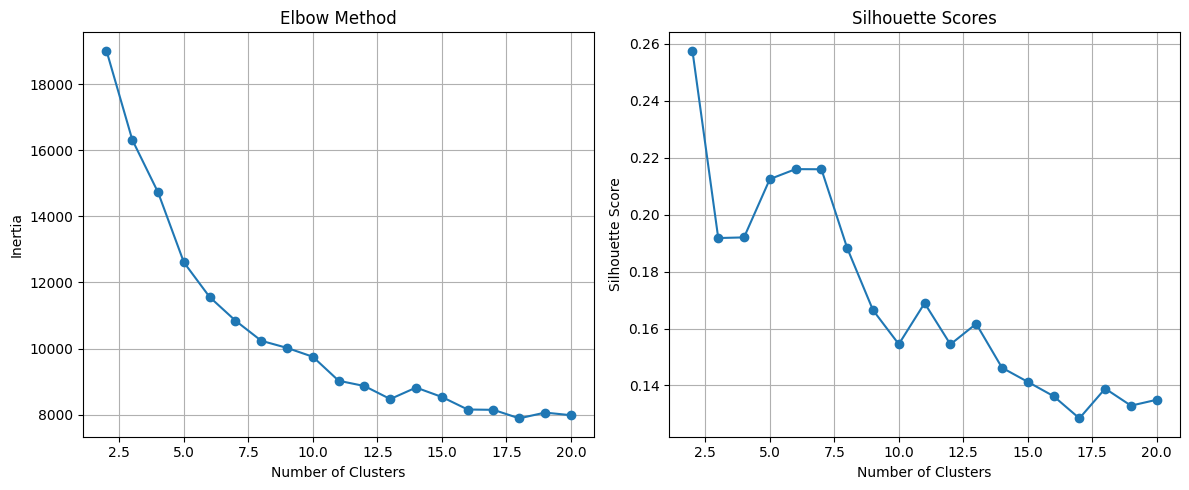

Optimal number of clusters: 2


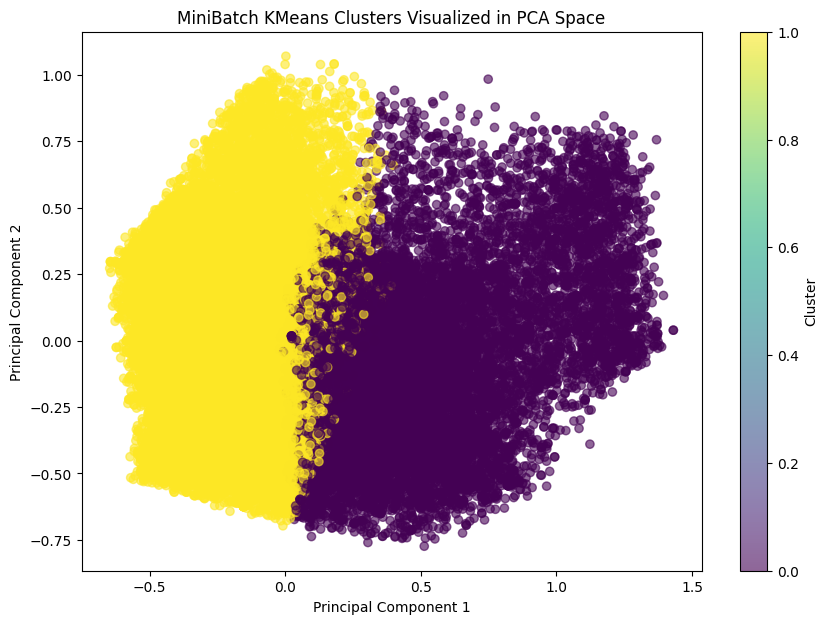

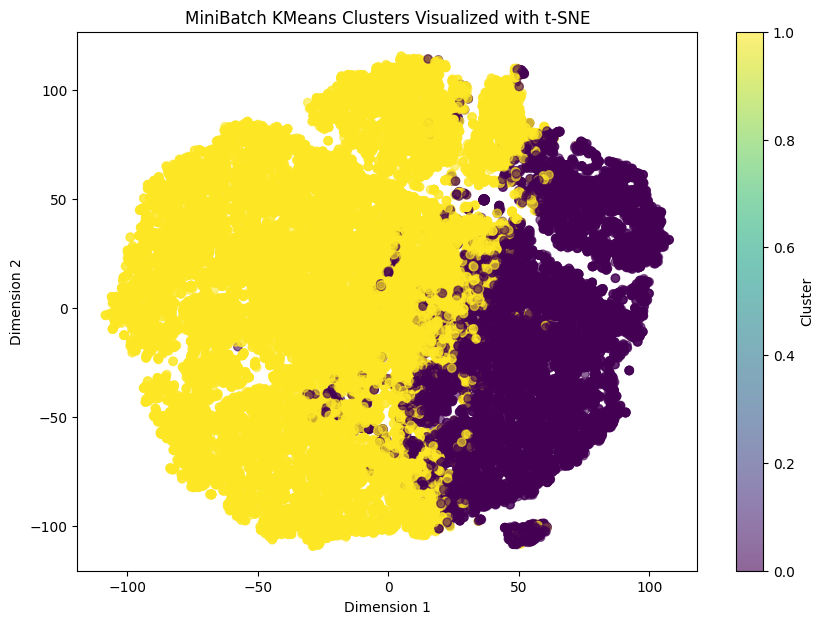

                           artists            album_name  \
113185            Hillsong Worship         No Other Name   
42819                 Internal Rot        Grieving Birth   
59311   Zhoobin Askarieh;Ali Sasha  Noise A Noise 20.4-1   
90416                   Billy Fury      A Thousand Stars   
61000                   Nogizaka46            バレッタ TypeD   

                    track_name  popularity  duration_ms  explicit  \
113185           No Other Name          50       440247     False   
42819           Failed Organum          11        93933     False   
59311    Save the Trees, Pt. 1           0       213578     False   
90416   It's Only Make Believe          34       146706     False   
61000                    月の大きさ          57       236293     False   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
113185         0.369   0.598    7    -6.984     1       0.0304       0.00511   
42819          0.171   0.997    7    -3.586     1       0.1180  

In [2]:

# Sample 40% of the data
train_data = train_data.sample(frac=0.4, random_state=42)

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(train_data[features])

# Hyperparameter tuning for number of clusters
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 21)  # Adjust the range as necessary

for n_clusters in range_n_clusters:
    miniBatchKMeans_model = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)
    cluster_labels = miniBatchKMeans_model.fit_predict(X)
    inertia.append(miniBatchKMeans_model.inertia_)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# Plot the Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)

# Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Choose the optimal number of clusters based on the Silhouette Scores
optimal_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 because index starts at 0
print(f"Optimal number of clusters: {optimal_n_clusters}")

# Train the final MiniBatch KMeans Model with optimal clusters
final_model = MiniBatchKMeans(n_clusters=optimal_n_clusters, random_state=42, batch_size=100)
train_data['cluster'] = final_model.fit_predict(X)

# Save the scaler and MiniBatchKMeans model separately
model_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'models'))
model_path = os.path.join(model_dir, 'miniBatchKMeans_model.pkl')
scaler_path = os.path.join(model_dir, 'MinMaxScaler.pkl')

joblib.dump(scaler, scaler_path)
joblib.dump(final_model, model_path)

# Save the clustered training data
train_data.to_csv("miniBatchKMeans_model_data.csv", index=False)

# Visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_data['cluster'], cmap='viridis', alpha=0.6)
plt.title('MiniBatch KMeans Clusters Visualized in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Optional: Visualization using t-SNE for better separation
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_data['cluster'], cmap='viridis', alpha=0.6)
plt.title('MiniBatch KMeans Clusters Visualized with t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

# Display first 5 rows of the clustered data
print(train_data.head(5))
